In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta']


##  Data reading

In [3]:
run         = 'Run11'
run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 9
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 30


In [4]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_dir)[:nfiles]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)


In [5]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes,
                                             sample_binning = sample_binning
                                             )  
        dataframes.append(df)

Reading .bin files: 100%|██████████| 30/30 [00:58<00:00,  1.96s/file]


In [6]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

In [7]:
df = merged_df
df.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,event,event_time,file_idx
11279995,0.000006,1.839060,-371.527679,-405.346924,-405.899078,-126.106819,-347.213593,-545.022827,-404.331512,-493.779999,14999,180191552411,29
11279996,0.000006,1.884348,-371.527679,-332.490051,-405.530396,-152.971985,-347.397675,-547.905579,-404.208496,-501.143463,14999,180191552411,29
11279997,0.000006,1.731960,-371.527679,-237.720871,-406.636383,-184.130676,-348.072601,-547.721558,-404.639099,-514.213562,14999,180191552411,29
11279998,0.000006,1.673208,-370.360321,-143.197205,-406.759277,-216.209396,-348.072601,-550.358948,-405.008179,-529.492676,14999,180191552411,29
11279999,0.000006,1.709928,-369.745911,-62.729340,-407.189392,-246.938736,-348.072601,-555.449768,-405.500275,-542.869629,14999,180191552411,29


##  Data selection

In [8]:
# Filter for a specific event (change index as needed)
event_list  = df['event'].unique()
nevents     = len(event_list)
print(f'Unfiltered df nevents = {nevents}')

Unfiltered df nevents = 15000


In [9]:
noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8']
Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9']

all_channels    = noAmp_channels + Amp_channels

In [10]:
selected_event = 100
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event


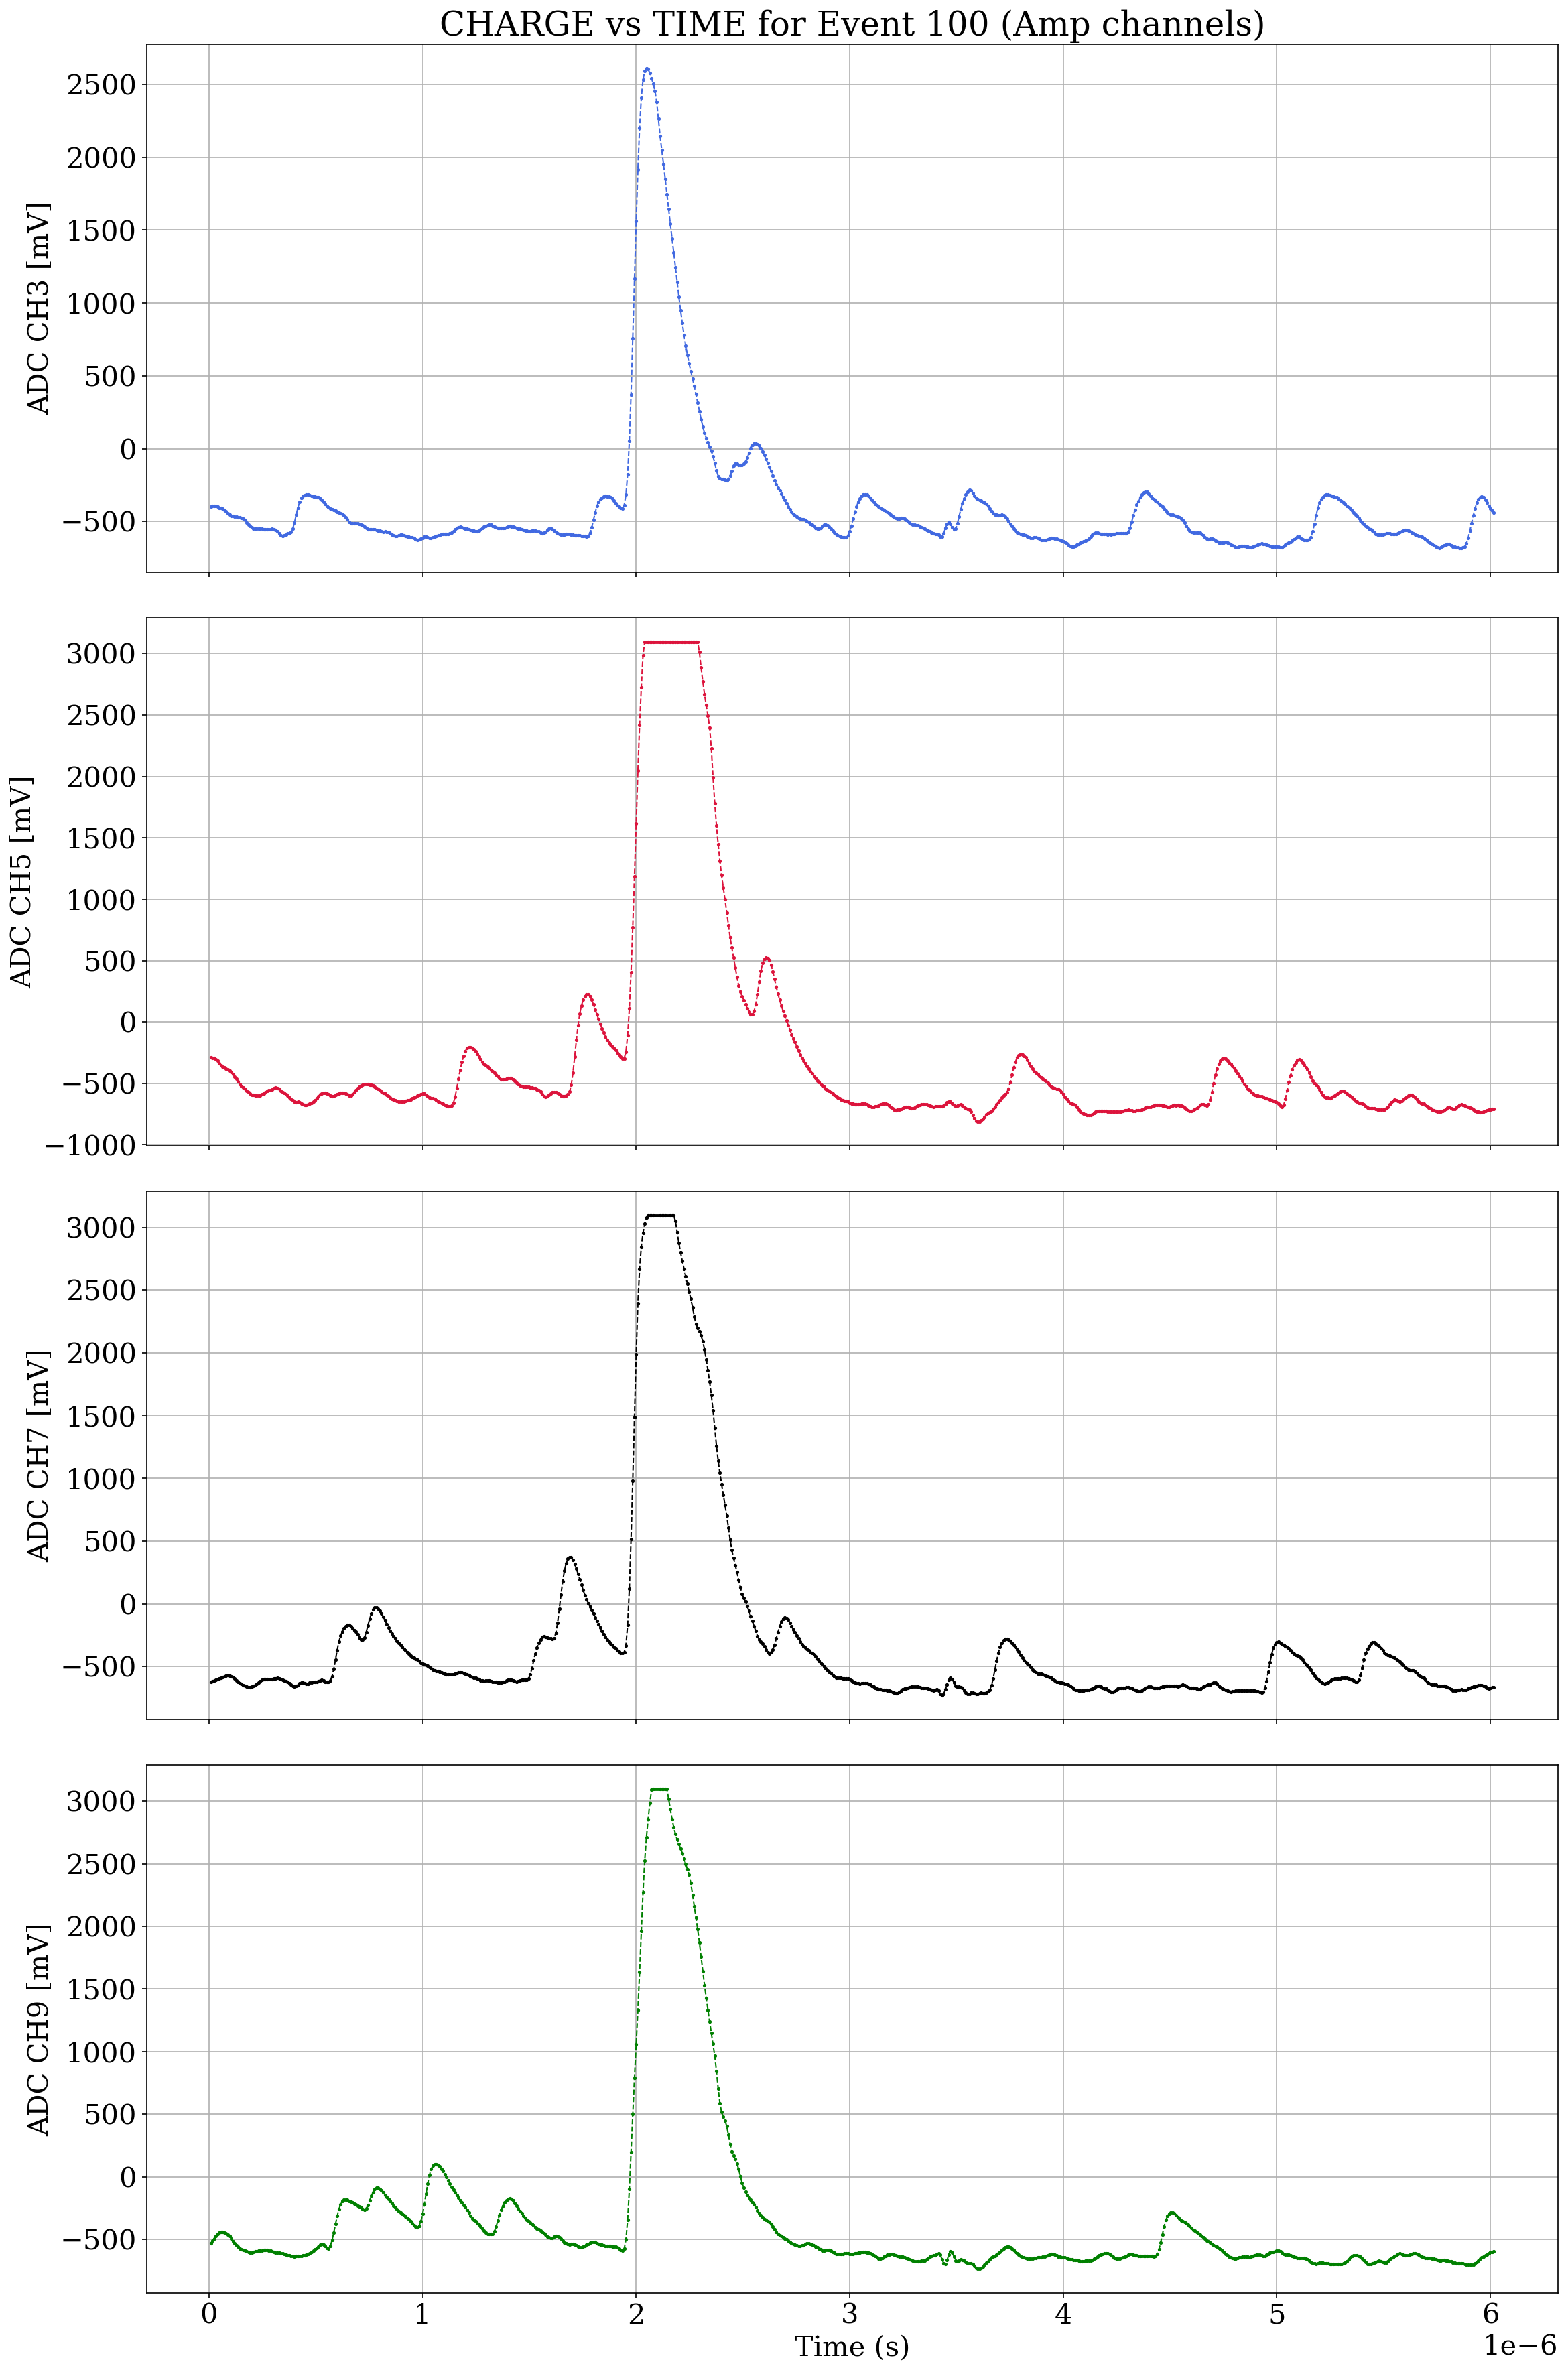

In [11]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]} (Amp channels)')

else:
    ax.set_title(f'CHARGE vs TIME for Event {event_list[selected_event]} (Amp channels)')

# Plot CHs
for i in range(len(Amp_channels)):

    if len(Amp_channels) > 1:
        ax = axs[i]

    ax.plot(df_event['TIME'].values, df_event[f'{Amp_channels[i]}'].values, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{Amp_channels[i]}')
    ax.set_ylabel(f'ADC {Amp_channels[i]} [mV]')
    ax.grid(True)

if len(Amp_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')
# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Data filtering

In [12]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, threshold=1000):
    peak_count = 0
    for ch in Amp_channels:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts = df.groupby("event").apply(count_high_peaks)

# keep only events with <= 5 peaks above 2000
valid_events = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = df[df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)
print(f'Filtered df nevents = {nevents}')

Filtered df nevents = 3281


/tmp/ipykernel_582792/1341809093.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts = df.groupby("event").apply(count_high_peaks)


In [13]:
# DEFINITION OF THE BASELINE WINDOW WITH HERE
window_width = 20


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)
/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)
/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)


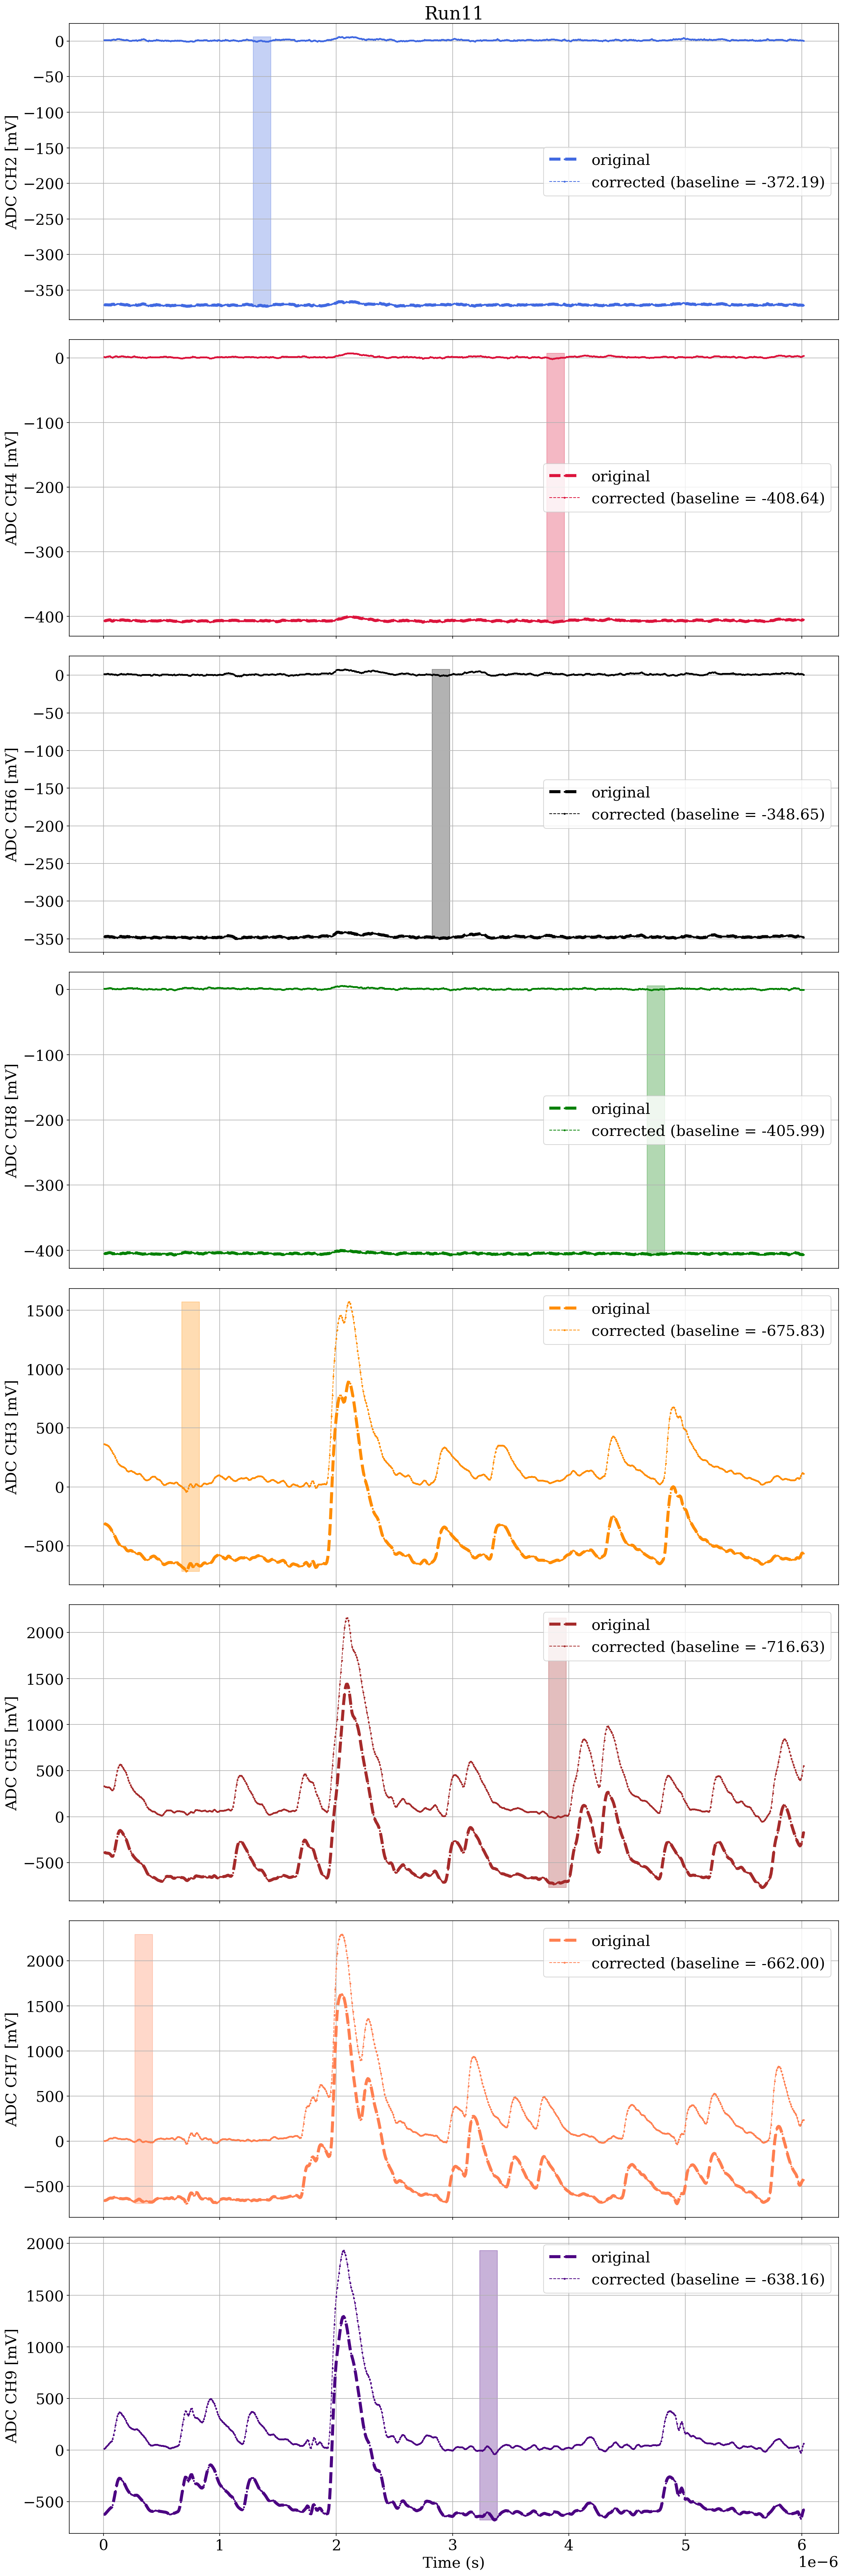

In [14]:
# Create subplots: 2 rows, 1 column

selected_ev = 20

if len(all_channels) > 1:
    fig, axs = plt.subplots(len(all_channels), 1, figsize=(16, len(all_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(all_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(all_channels):

    if len(all_channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{all_channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_ev], v_matrix[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=4, label=f'original')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected (baseline = {baselines[selected_ev]:.2f})')
    

    start = max(window[selected_ev], 0)
    end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    ax.fill_between(time[start:end], 
                    min(v_matrix_corrected[selected_ev].min(), v_matrix[selected_ev].min()), 
                    max(v_matrix_corrected[selected_ev].max(), v_matrix[selected_ev].max()), 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Amplification

In [15]:
t_matrix = filtered_df['TIME'].values.reshape(nevents, -1)
time = t_matrix[0]

/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)
/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)
/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)


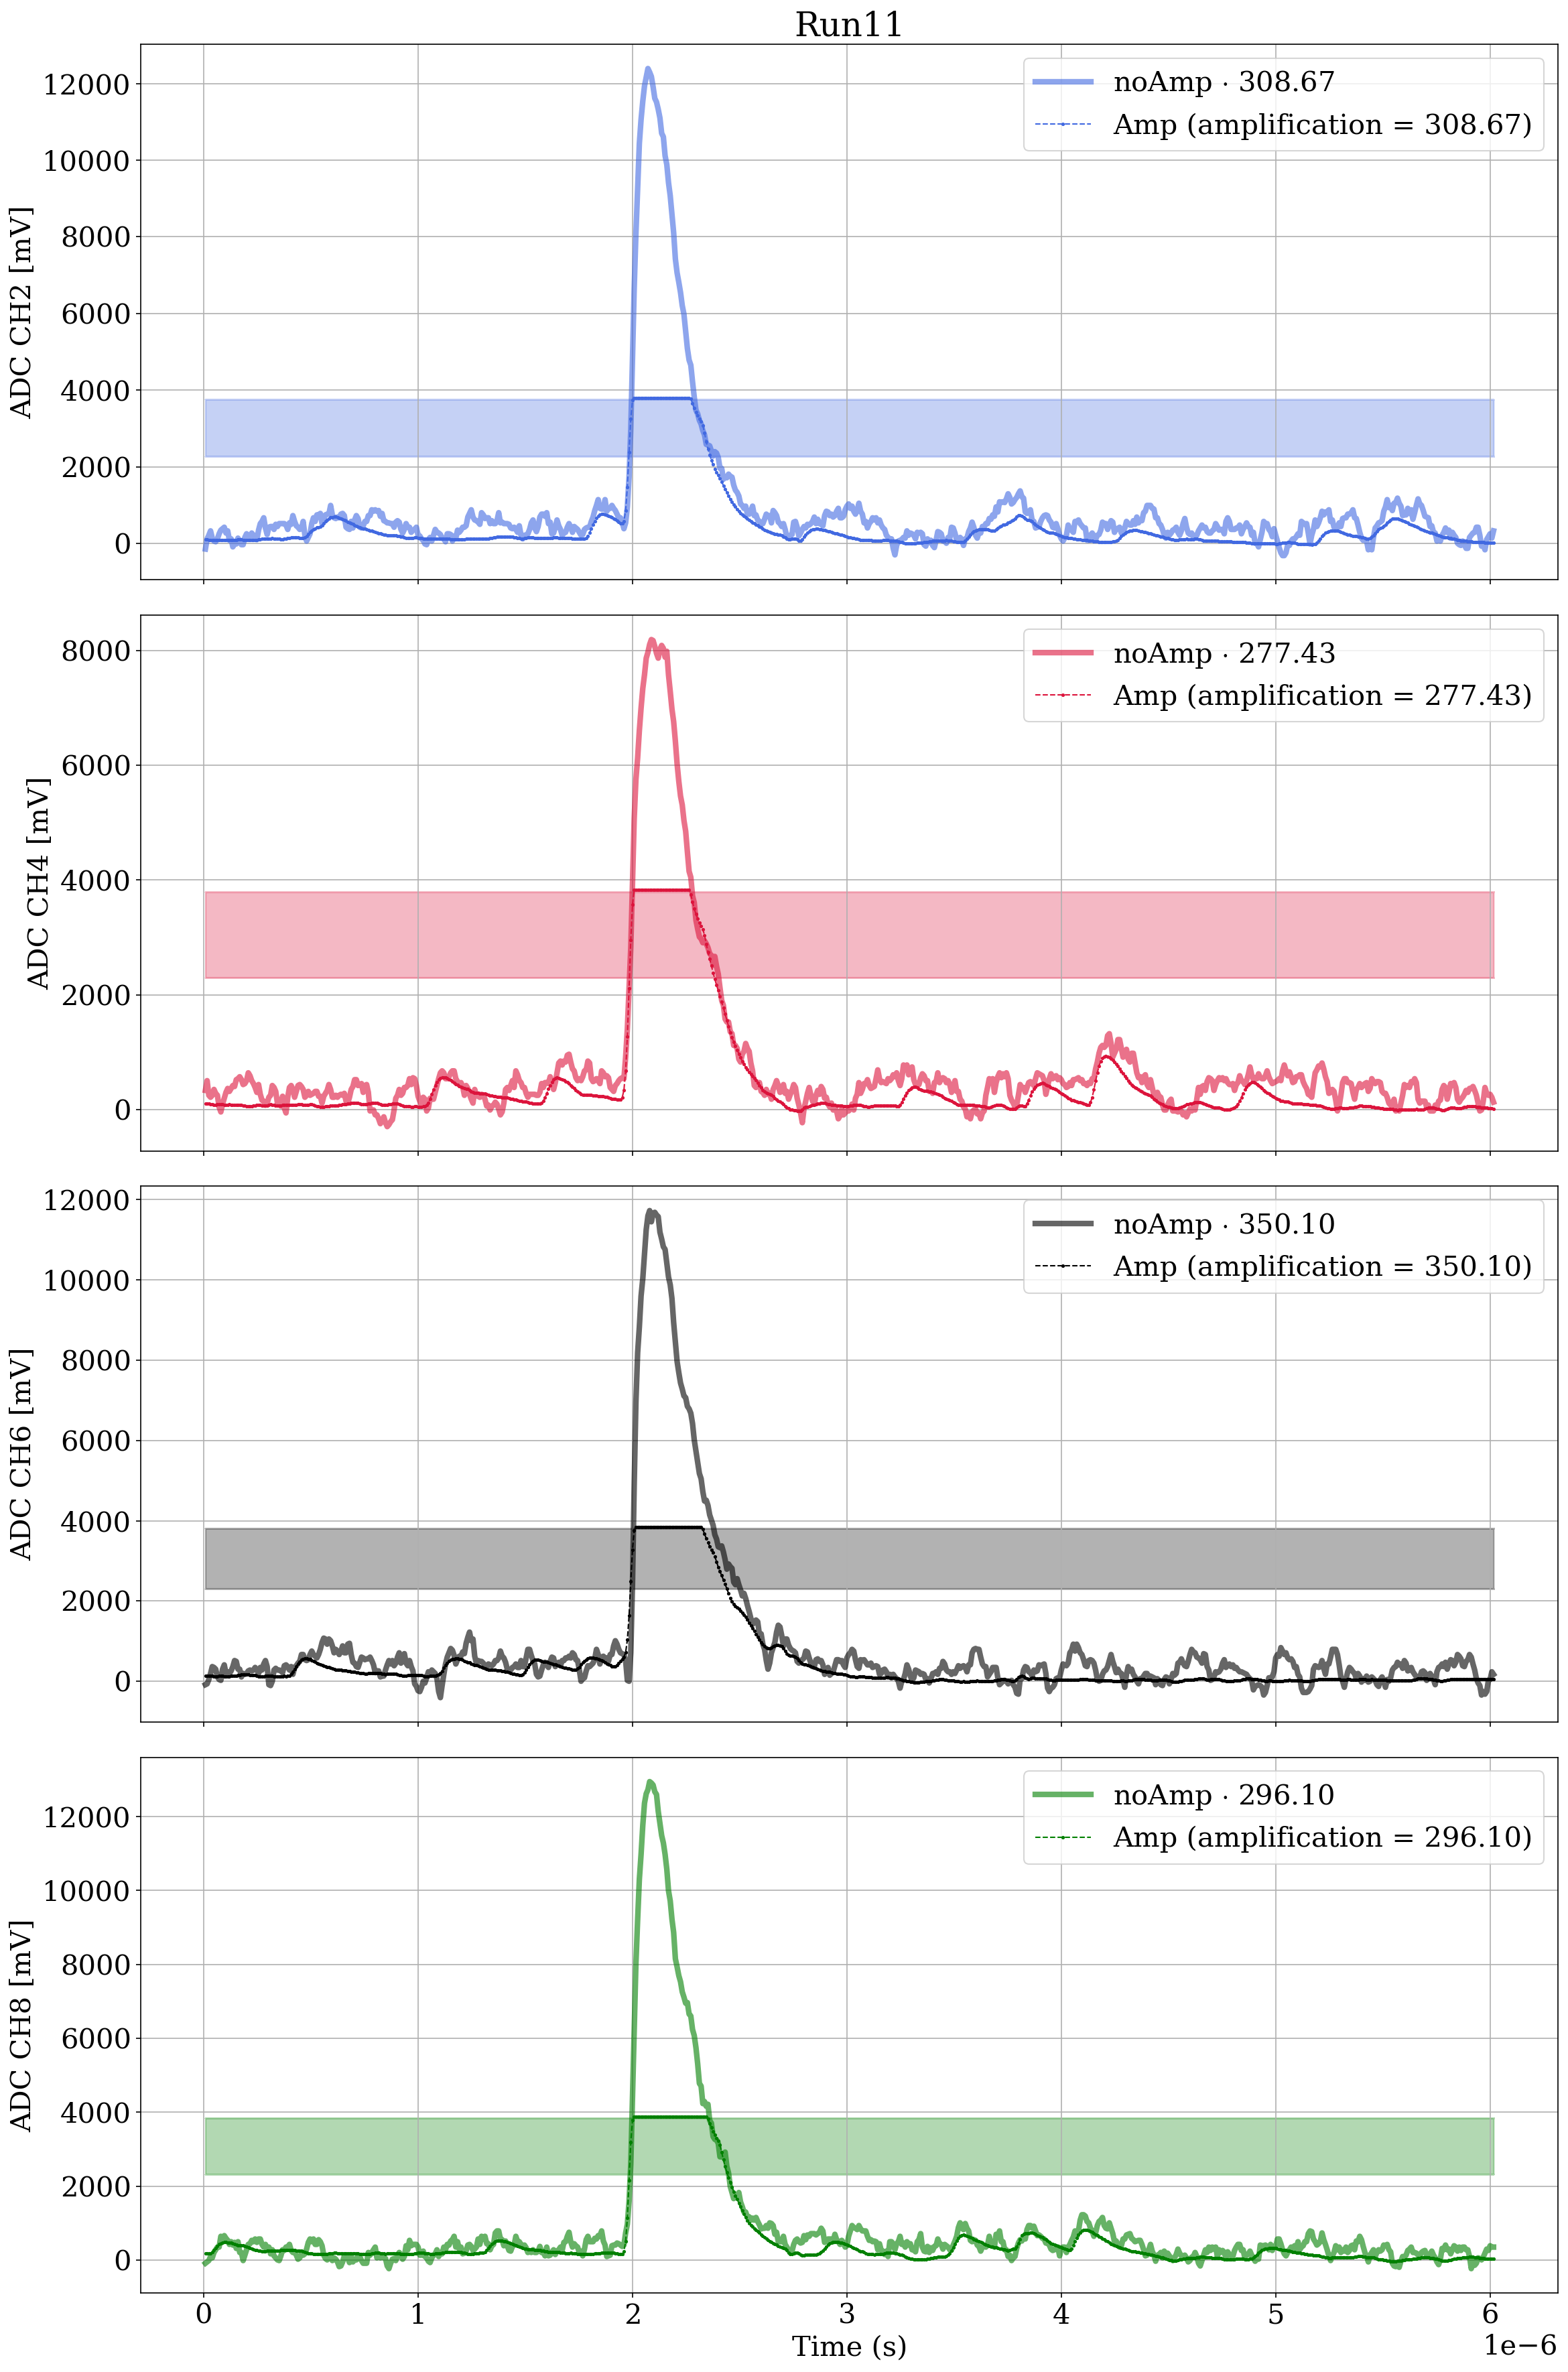

In [16]:
# Create subplots: 2 rows, 1 column

selected_ev = 287


if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    Amp_min_th      = v_matrix_corrected_Amp[selected_ev].max()*0.6
    Amp_saturation  = v_matrix_corrected_Amp[selected_ev].max()*0.99

    amp_mask    = (v_matrix_corrected_Amp[selected_ev] > Amp_min_th) & (v_matrix_corrected_Amp[selected_ev] < Amp_saturation) # don't get saturation values either
    # Avoid division by zero or tiny denominators
    safe_mask = np.abs(v_matrix_corrected_noAmp[selected_ev]) > 1e-6
    valid_mask = amp_mask & safe_mask

    amp         = (v_matrix_corrected_Amp[selected_ev][valid_mask]/v_matrix_corrected_noAmp[selected_ev][valid_mask]).mean()
    # amp = np.nanmean(v_matrix_corrected_Amp/v_matrix_corrected_noAmp, axis = 1).mean()

    ax.plot(t_matrix[selected_ev], amp*v_matrix_corrected_noAmp[selected_ev], marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, label=fr'noAmp $\cdot$ {amp:.2f}')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected_Amp[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'Amp (amplification = {amp:.2f})')
    

    ax.fill_between(time, Amp_min_th, Amp_saturation, 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)


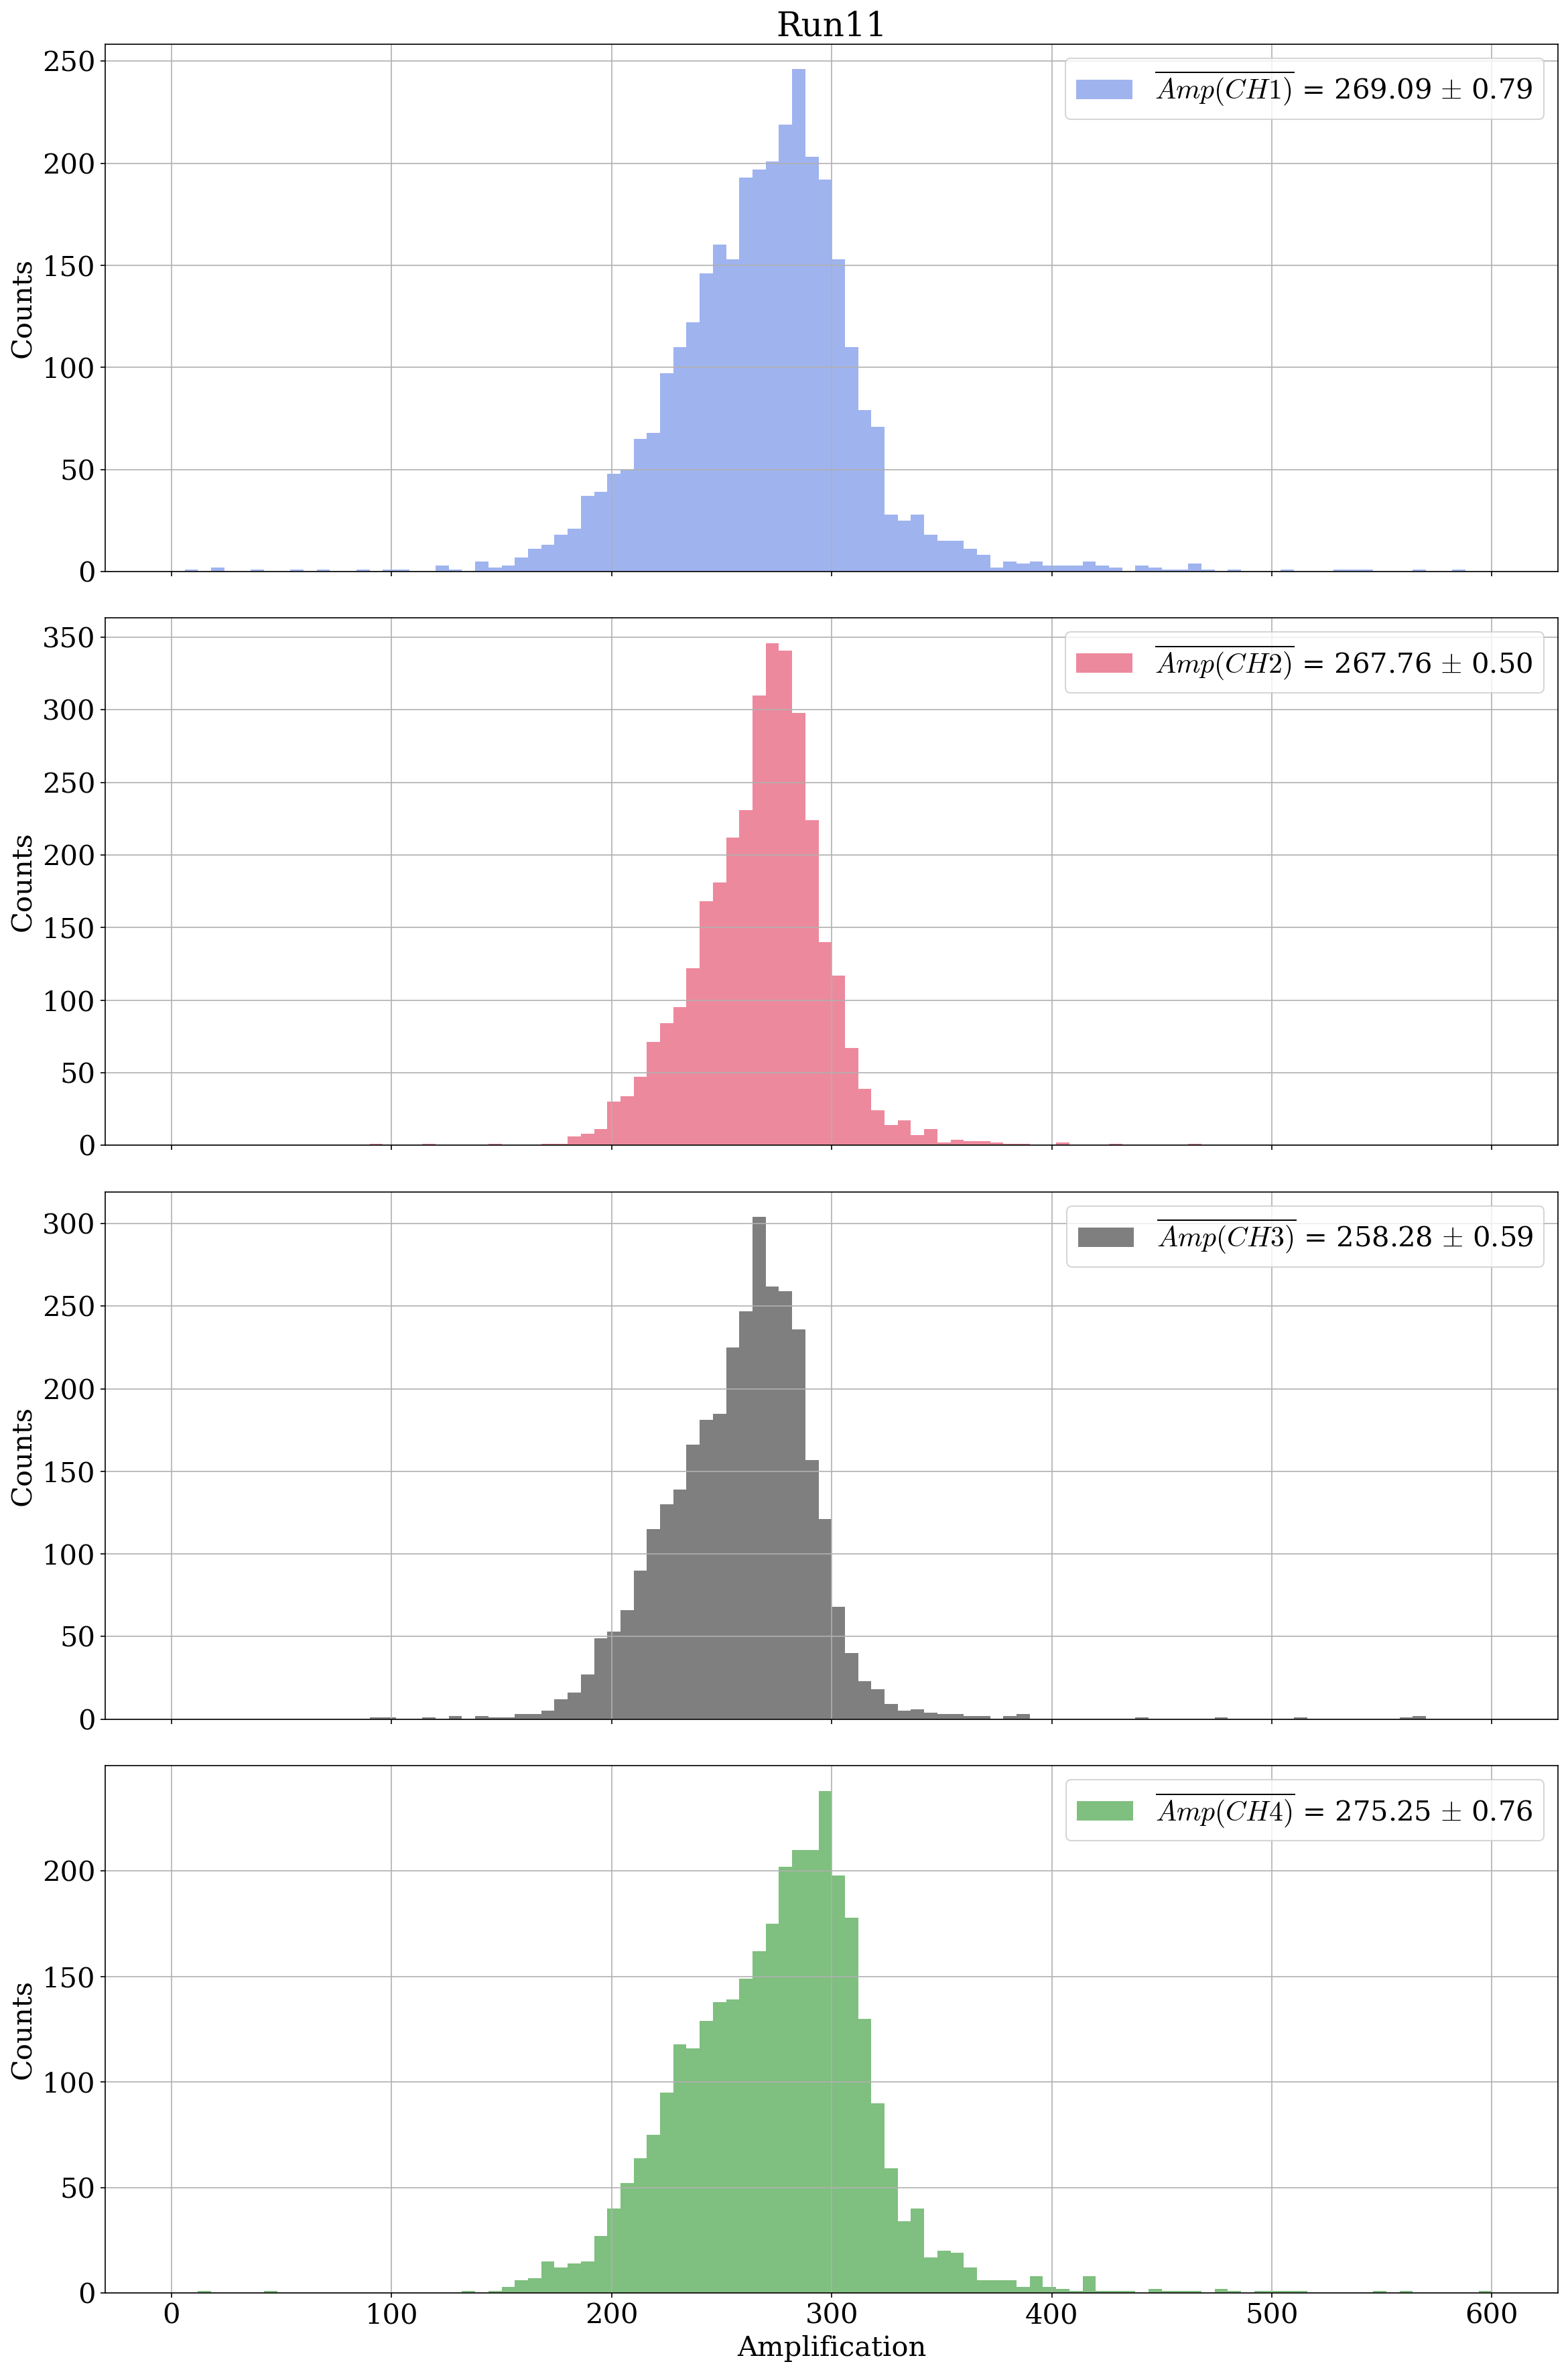

In [17]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time    = filtered_df['TIME'].values
amp     = {}

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    Amp_max = v_matrix_corrected_Amp.max(axis=1)             # (nevents,)
    Amp_min_th = Amp_max * 0.6                               # (nevents,)
    Amp_saturation = Amp_max * 0.99                          # (nevents,)

    amp_mask = (v_matrix_corrected_Amp > Amp_min_th[:, None]) & (v_matrix_corrected_Amp < Amp_saturation[:, None]) # (nevents, nsamples)
    # Avoid division by zero or tiny denominators
    safe_mask = np.abs(v_matrix_corrected_noAmp) > 1e-6
    valid_mask = amp_mask & safe_mask

    # Compute ratio only where valid
    ratio = np.divide(
        v_matrix_corrected_Amp,
        v_matrix_corrected_noAmp,
        out=np.full_like(v_matrix_corrected_Amp, np.nan),
        where=valid_mask
    ) # (nevents, nsamples)

    # Mean amplification per event
    amp[f'CH{i+1}'] = np.nanmean(ratio, axis=1)  # shape: (nevents,)

    ch_amp = np.nanmean(amp[f'CH{i+1}'])

    events, bins, image = ax.hist(amp[f'CH{i+1}']
                                ,bins = 100 
                                ,range = (0, 600)
                                ,density = False
                                ,color = colors[i]
                                ,alpha = 0.5
                                ,label = fr'$\overline{{Amp(CH{i+1})}}$ = {ch_amp:.2f}'
                                )
    
    # Bin centers and weighted mean/std
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    hist_mean = np.average(bin_centers, weights=events)
    hist_var = np.average((bin_centers - hist_mean) ** 2, weights=events)
    hist_std = np.sqrt(hist_var)
    N = np.sum(events)
    hist_sem = hist_std / np.sqrt(N) if N > 0 else np.nan

    # Update legend label
    image[0].set_label(fr'$\overline{{Amp(CH{i+1})}}$ = {hist_mean:.2f} $\pm$ {hist_sem:.2f}')


    ax.set_ylabel(f'Counts')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Amplification')
else:
    ax.set_xlabel('Amplification')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()